[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/14qvQmm62H2DMRmNClzYIpJyl2LVLJF2l#scrollTo=gB0w58uTYyc9)

# Predict the probabilities that 5-day future returns of tickers will fall in the top 20% (category prediction)

In [ ]:
!python --version

Python 3.11.12


## Library

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os

Mounted at /content/drive


In [ ]:
# Library
import pandas as pd
import numpy as np
import math
import random
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import plotly.express as px
from tqdm import tqdm
from time import process_time

from pandas.tseries.holiday import USFederalHolidayCalendar

In [ ]:
import yfinance as yf
from datetime import datetime, timedelta
import pytz

In [ ]:
# To plot training loss curves
!pip install -q plot_keras_history

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.5/324.5 kB 17.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from plot_keras_history import show_history, plot_history

In [ ]:
print('TF Version:', tf.__version__)

TF Version: 2.18.0


In [ ]:
# Libraries for linear regression from scikit-learn
from scipy import stats
from sklearn import model_selection
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import ElasticNetCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import metrics

In [ ]:
# Stat libraries
import statsmodels.api as sm

In [ ]:
# Output path in Google Drive
#stMarketDfPath = '/content/drive/My Drive/Colab Notebooks/2023_FinancialAssets/Analysis/trimmedReturn/'
#outputPath = '/content/drive/My Drive/Colab Notebooks/2023_FinancialAssets/Analysis/MOLP_models/'
#outputPath2 = '/content/drive/My Drive/Colab Notebooks/2023_FinancialAssets/Analysis/MOLP_seqPred/'
workingPath = '/content/drive/My Drive/Colab Notebooks/DS_examples'

## Functions

In [ ]:
# Plot a date-indexed Series
def plotPriceSeries(dateIndexedSeries, companyName, figWidth=1200, figHeight=350, symbol="", returnRecent=None):
    """
    Plotly plot a date-indexed price 'Series' object.
    """

    x = dateIndexedSeries
    # Date
    d0 = datetime.date(x.index[0])
    d1 = datetime.date(x.index[-1])

    # Stats
    if returnRecent is None:
        returnStartInd = 0
    else:
        returnStartInd = -1 - returnRecent      # to compute recent (returnRecent)-day return

    x_forStats = x[returnStartInd:]
    r_x = round((x_forStats[-1] - x_forStats[0])/x_forStats[0] * 100, 2)

    m_x = np.mean(x_forStats)
    v_x = np.var(x_forStats)
    cv_x = round(np.sqrt(v_x) / m_x * 100, 2)

    # Plotly plot
    if symbol == "":
        title0 = companyName + ' (' + str(d0) + ' -- ' + str(d1) + ") <br>" + '[return] ' + str(r_x) + '%, ' + '[C.V.] ' + str(cv_x) + '%'
    else:
        title0 = companyName + ' ('+symbol+')' + ' (' + str(d0) + ' -- ' + str(d1) + ") <br>" + '[return] ' + str(r_x) + '%, ' + '[C.V.] ' + str(cv_x) + '%'

    fig = px.line(x=dateIndexedSeries.index, y=dateIndexedSeries.values, markers=True)
    fig.update_layout(width=figWidth, height=figHeight)
    fig.update_layout(title=title0, xaxis_title='', yaxis_title='Adj Close')
    fig.update_xaxes(rangebreaks=[ dict( bounds=["sat", "mon"] ) ])
    fig.add_hline(y=x_forStats[0], line_dash="dash", line_color="black", line=dict(width=1))
    fig.add_hline(y=x_forStats[-1], line_dash="dash", line_color="blue", line=dict(width=1))
    fig.show()

    return fig

In [ ]:
# Make a lagged matrix from a column array
def columnToLaggedMatrix(colOfArr, maxLag, colName):
    # Make a lagged matrix from a column array

    n = len(colOfArr)
    Lmat = np.zeros(shape = (n, maxLag + 1))
    Lmat[:, 0] = colOfArr
    Lmat_colNames = []
    Lmat_colNames.append(colName)

    for h in range(1, maxLag + 1):
        tmp = np.roll(colOfArr, h)
        tmp2 = np.array(h * [np.nan])
        tmp3 = np.concatenate((tmp2, tmp[h:]))
        Lmat[:, h] = tmp3
        Lmat_colNames.append( (colName + '_' + str(h)) )

    return Lmat, Lmat_colNames

In [ ]:
# LassoCV fit and summarize output
def LassoCVfit_summarize(X_train, y_train, FeatureLaggedDf2, X_test, printFlag=True, verbose=True):
    # Fit LassoCV and summarize its output
    # 6 output: cvfit, numNz, featnames0, sortedCoefDf, trR2, pred_test

    # LassoCV
    t0 = process_time()
    modelCV = LassoCV(cv = 4, max_iter=10000, verbose=verbose, n_alphas=10)
    cvfit = modelCV.fit(X_train, y_train)
    if printFlag:
        print(process_time() - t0)

    # cvfit info
    numNz = (cvfit.coef_ != 0).sum()

    tmp = cvfit.coef_.nonzero()
    featnames0 = FeatureLaggedDf2.columns[tmp[0]]

    coefDf = pd.DataFrame(index=featnames0)
    nonzeroCoef = cvfit.coef_[tmp[0]]
    coefDf['nonzeroCoef'] = nonzeroCoef
    sortedCoefDf = coefDf.sort_values(by='nonzeroCoef', ascending=False)

    pred_train = cvfit.predict(X_train)
    trR2 = r2_score(y_train, pred_train)

    # Predict one row
    pred_test = cvfit.predict(X_test)

    # Print
    if printFlag:
        print(numNz)
        print(*featnames0, sep=',')
        print(sortedCoefDf.transpose().to_string(index=False))
        print("Train R2: " + str(trR2))
        print(pred_test)

    return cvfit, numNz, featnames0, sortedCoefDf, trR2, pred_test

In [ ]:
# ADF testing
def ADFtesting(y, pred, printFlag=True):
    # Apply ADF testing to a residual time series

    resid = y - pred
    if printFlag:
        fig = plt.subplots(figsize=(8,2))
        #plt.plot(resid); plt.axhline(y=0, color='gray', linewidth=0.5)
        plt.plot(y); plt.plot(pred)

    testout = sm.tsa.adfuller(resid, maxlag=3, autolag='AIC')
    Pvalue = testout[1]
    print(testout)
    print("====")
    print("P-value: " + str(Pvalue))
    if (Pvalue < 0.05):
        print("Stationary residual!")
    else:
        print("Non-stationary residual!")

    return testout

In [ ]:
# Prepare dataframes for seqLassoCV
def prepareData_forMOLP(returnDf_sc, explanatoryLag, printFlag=False):
    # Prepare dataframes to augment lagged variables
    # Input:
    #     - returnDf_sc: scaled daily return DF
    # Output: FeatureLaggedDf2

    nrow0 = returnDf_sc.shape[0]

    # Augment lagged features (returnDf_sc -> FeatureLaggedDf)
    FeatureArr = returnDf_sc.values

    # Make a lagged array for the 1st col
    col_1 = FeatureArr[:, 0]
    laggedMat, colNames = columnToLaggedMatrix(col_1, explanatoryLag, returnDf_sc.columns[0])
    FeatureLaggedArr = laggedMat

    # Append lagged arrays for the rest of columns
    for j in range(1, FeatureArr.shape[1]):
        col_j = FeatureArr[:, j]
        laggedMat, colNames_j = columnToLaggedMatrix(col_j, explanatoryLag, returnDf_sc.columns[j])
        FeatureLaggedArr = np.concatenate((FeatureLaggedArr, laggedMat), axis=1)
        # Make colnames for lagged column_j
        for k in range(explanatoryLag + 1):
            colNames.append(colNames_j[k])

    FeatureLaggedDf = pd.DataFrame(FeatureLaggedArr)
    FeatureLaggedDf.columns = colNames
    FeatureLaggedDf.index = returnDf_sc.index

    # Truncated the first a few rows with NaNs (FeatureLaggedDf -> FeatureLaggedDf2)
    FeatureLaggedDf2 = FeatureLaggedDf.iloc[explanatoryLag:, :]

    # Dfs for sequential prediction
    # FeatureLaggedDf2 nrow = trainLength + testLength + (predLag - 1) + predLag  (to predict upto h-day future)
    if printFlag:
        print("== FeatureLaggedDf2: ")
        print("== Head index:")
        print(FeatureLaggedDf2.head(10).index)
        print("== Tail index:")
        print(FeatureLaggedDf2.tail(10).index)
        print("Matrix dimension")
        print(FeatureLaggedDf2.shape)

    return FeatureLaggedDf2

In [ ]:
# Apply LassoCVfit_summarize() sequentially
def seqLassoCVfit_summarize(symbol0, testLength, FeatureLaggedDf2, ResponseDf2, printFlag=False, LassoCVprintFlag=False):
    # Apply LassoCVfit_summarize() sequentially
    # Parameters
    # ----------
    # symbol0 : ticker for a target variable
    # testLength : length of the sequential prediction period
    # Output (7) : yDf_testSeq, fitList, numNonzeros, selectedFeatures, sortedCoefDfs, trainR2s, seqPred

    ncolLagged = FeatureLaggedDf2.shape[1]

    # Target time series
    yDf = ResponseDf2[symbol0]
    yDf_testSeq = yDf.iloc[-testLength:]

    # Initialize output objects
    fitList = list()
    numNonzeros = list()
    selectedFeatures = list()
    trainR2s= list()
    sortedCoefDfs = list()
    seqPred = list()

    if printFlag:
        print("== y testing period")
        print(yDf_testSeq.index)

    # Sequential LassoCV prediction
    for seqid in range(testLength + predLag):
        print("[" + str(seqid) + "]", end="")

        # Define index ranges that run sequentially
        trainRows = np.arange(seqid, trainLength + seqid)
        testRow = trainLength + (predLag - 1) + seqid           # h-day future

        # Define train/test data frames
        yDf_tr = yDf.iloc[trainRows]
        FeatureLaggedDf2_tr = FeatureLaggedDf2.iloc[trainRows, :]
        FeatureLaggedDf2_te = FeatureLaggedDf2.iloc[testRow, :]

        # Define design matrixes
        X_train = FeatureLaggedDf2_tr.values;     #print(X_train.shape)
        y_train = yDf_tr.values;                  #print(y_train.shape)
        X_test = FeatureLaggedDf2_te.values.reshape((1, ncolLagged));    #print(X_test.shape)
        if printFlag:
            print("Last date of X_train: " + str(FeatureLaggedDf2_tr.tail(1).index))
            print("Last date of y_train: " + str(yDf_tr.tail(1).index))
            print("The date of X_test (one row): " + str(FeatureLaggedDf2_te.name))

        # LassoCVfit_summarize()
        cvfit, numNz, featnames0, sortedCoefDf, trR2, pred_test = LassoCVfit_summarize(X_train, y_train, FeatureLaggedDf2, X_test, printFlag=LassoCVprintFlag, verbose=False)

        # Store each prediction output
        fitList.append(cvfit)
        numNonzeros.append(numNz)
        selectedFeatures.append(featnames0)
        sortedCoefDfs.append(sortedCoefDf)
        trainR2s.append(trR2)
        pred_test0 = pred_test[0]
        seqPred.append(pred_test0)
        if printFlag: print("====\n")

    return yDf_testSeq, fitList, numNonzeros, selectedFeatures, sortedCoefDfs, trainR2s, seqPred

In [ ]:
# Convert a sequential prediction vector to a date-indexed series
def get_dateIndex_forSeqPred(seqPred, yDf_testSeq):
    # Convert a sequential prediction vector to a date-indexed series

    # Make a extended series for the seqPred list
    today = yDf_testSeq.index[-1];    #print(today)
    seqPredSer = yDf_testSeq.copy()

    # Make h-day ahead more rows
    k = 1
    while(len(seqPredSer) < len(seqPred)):
        kdayAhead = today + timedelta(days = k)
        if (kdayAhead.weekday() < 5):
            seqPredSer.loc[kdayAhead] = np.nan
        k = k + 1

    # Date indexed
    pred_test = pd.Series(seqPred, index=seqPredSer.index)

    return pred_test

### MLP sub-functions

In [ ]:
# MLP model specifier (any layer sizes and drop-out indicators)
def MLP_specifier(inputlsize, layerSizeVec, dropOutIndicVec, outputlsize, activationFtnName, outputActivationFtnName, dropoutRate = 0.0):

    # Sequential model
    MLP1 = tf.keras.Sequential()
    # Input layer
    MLP1.add(tf.keras.Input(shape=(inputlsize,)))

    # Number of hidden layers
    numLayers = len(layerSizeVec)
    if (len(layerSizeVec) != len(dropOutIndicVec)):         # Checking consistency of number of layers
        raise ValueError("====  Lengths of layerSizeVec and dropOutIndicVec are differnet.")

    # Build hidden layers
    for d in range(numLayers):
        MLP1.add(layers.Dense(layerSizeVec[d], activation=activationFtnName))
        if (dropOutIndicVec[d] == 1):
            MLP1.add(layers.Dropout(dropoutRate))

    # output layer
    MLP1.add(layers.Dense(outputlsize, activation=outputActivationFtnName))

    return MLP1

In [ ]:
# Def of training/test time frames
# (eg) predlag = 5
# Time --->           (t_current)
#                               -
#                               (t_latest date)
#                                             -
#                       X_tr
# --------------------------
#                            y_tr
#      --------------------------
#                            X_te
#                      ----------
#                                 y_te
#                                ****----------

In [ ]:
# Define train/test data matrixes
def set_train_test_matrix_for_periodPrediction(FeatureLaggedDf3, ResponseDf3, nrowsOneday, trainLength, predLag, testLength):
    # Define train/test matrix depending on a sequential testing id
    # Input: FeatureLaggedDf3, ResponseDf3, nrowsOneday, seqid

    # Define index ranges that run sequentially
    trainRows = np.arange(0, (trainLength) * nrowsOneday)
    testRows = (trainLength + (predLag - 1)) * nrowsOneday + np.arange(0, testLength * nrowsOneday)           # h-day future

    print("== ResponseDf3 ")
    print(ResponseDf3.head(6))
    print(ResponseDf3.tail(6))

    # Define train/test data frames
    yDf_tr = ResponseDf3.iloc[trainRows]
    FeatureLaggedDf3_tr = FeatureLaggedDf3.iloc[trainRows, :]
    yDf_te = ResponseDf3.iloc[testRows]
    FeatureLaggedDf3_te = FeatureLaggedDf3.iloc[testRows, :]
    #yDf_te = ResponseDf3.iloc[[]]

    # Indexes for train/test datasets
    print("== FeatureLaggedDf3_tr: ")
    print(FeatureLaggedDf3_tr.head(4).index)
    print(FeatureLaggedDf3_tr.tail(4).index)
    print("== FeatureLaggedDf3_te: ")
    print(FeatureLaggedDf3_te.head(4).index)
    print(FeatureLaggedDf3_te.tail(4).index)
    print("== yDf_tr: ")
    print(yDf_tr.head(4).index)
    print(yDf_tr.tail(4).index)
    #print("== yDf_te: None")
    print("== yDf_te: ")
    print(yDf_te.head(4).index)
    print(yDf_te.tail(4).index)

    # Define design matrixes
    X_train = FeatureLaggedDf3_tr.values;
    print(X_train.shape)
    y_train = yDf_tr.values;
    print(y_train.shape)
    X_test = FeatureLaggedDf3_te.values;
    print(X_test.shape)
    y_test = yDf_te.values
    print(y_test.shape)

    return X_train, y_train, X_test, y_test, yDf_tr, yDf_te

## Load stock return data

### Daily return (in %, features)

In [ ]:
# Import
returnDf1d0 = pd.read_csv(os.path.join(workingPath, 'returnDf_1days_pct.csv'), index_col=0)
returnDf1d0.shape

(530, 770)

In [ ]:
# csv input file for daily returns of stocks in S&P500
returnDf1d0

,symbol,name,2021-01-04,2021-01-05,2021-01-06,2021-01-07,2021-01-08,2021-01-11,2021-01-12,2021-01-13,...,2024-01-09,2024-01-10,2024-01-11,2024-01-12,2024-01-16,2024-01-17,2024-01-18,2024-01-19,2024-01-22,2024-01-23
0,A,Agilent Technologies,0.290793,0.817606,2.742238,2.660915,0.713379,0.857858,-0.920787,0.007882,...,-2.024301,0.313746,-1.075600,0.663171,-0.007656,-1.846322,1.826422,0.582550,1.013566,-0.841196
1,AAL,American Airlines Group,-4.058341,1.982817,0.583280,-0.902064,-1.625488,-0.859221,2.533334,0.975290,...,-1.371741,-0.208621,1.672472,-9.458534,-0.151404,-1.971185,6.883212,-1.157741,-0.292825,3.560937
2,AAPL,Apple Inc.,-2.471938,1.236376,-3.366131,3.412307,0.863141,-2.324902,-0.139541,1.622662,...,-0.226341,0.567140,-0.322255,0.177812,-1.231709,-0.517351,3.257068,1.553301,1.216330,0.536383
3,ABBV,AbbVie,-1.623888,1.034041,-0.863837,1.070276,0.524774,1.631410,0.697125,2.432120,...,0.545131,1.589552,-1.613199,0.104788,-0.566501,0.346791,0.777592,0.900184,0.376279,0.900840
4,ABNB,Airbnb,-5.211178,6.575645,-3.728927,5.953632,-0.991604,-1.095012,8.553296,5.715176,...,-0.392635,0.164836,-0.221807,-1.656506,-1.545862,-0.029632,1.526150,2.108873,1.486459,-0.408423
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
525,GC=F,Gold future to USD (USD of 1 Gold),2.725687,0.411375,-2.345467,0.283183,-4.089320,0.845101,-0.362238,0.580604,...,-0.009866,-0.231942,-0.366024,1.608494,-1.011382,-1.154986,0.798961,0.391362,-0.330617,0.574313
526,JPY=X,USD to JPY (JPY of 1 USD),0.114425,-0.110422,-0.433453,0.336976,0.743515,0.290011,0.035541,-0.361094,...,-0.335835,0.137279,0.904257,-0.472085,0.515699,0.995923,0.592202,0.006758,-0.004728,0.164053
527,NQ=F,Nasdaq 100 Sep 23,-1.552132,0.851366,-1.381561,2.466959,1.309174,-1.528947,-0.052338,0.636140,...,0.157703,0.683293,0.123929,0.017682,-0.016206,-0.570241,1.424147,1.919930,0.114689,0.146061
528,YM=F,Mini Dow Jones Indus.-$5 Sep 23,-1.288651,0.601249,1.436355,0.722656,0.164825,-0.293615,0.232995,-0.048428,...,-0.448159,0.458120,-0.023724,-0.355947,-0.632409,-0.252976,0.536601,1.024987,0.404784,-0.356030


In [ ]:
# Transpose returnDf
returnDf1d0.index = returnDf1d0['symbol']
returnDf1d = returnDf1d0.iloc[:, 2:]
returnDf1d = returnDf1d.transpose()
returnDf1d.shape

(768, 530)

In [ ]:
# Convert index to a datetime index
returnDf1d.index = pd.to_datetime(returnDf1d.index, format='%Y-%m-%d')
print(returnDf1d.head().index)
print(returnDf1d.tail().index)

DatetimeIndex(['2021-01-04', '2021-01-05', '2021-01-06', '2021-01-07',
               '2021-01-08'],
              dtype='datetime64[ns]', freq=None)
DatetimeIndex(['2024-01-17', '2024-01-18', '2024-01-19', '2024-01-22',
               '2024-01-23'],
              dtype='datetime64[ns]', freq=None)


In [ ]:
returnDf1d

symbol,A,AAL,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,...,CL=F,CNY=X,ES=F,EURUSD=X,GBPUSD=X,GC=F,JPY=X,NQ=F,YM=F,ZB=F
2021-01-04,0.290793,-4.058341,-2.471938,-1.623888,-5.211178,-0.347052,-3.243688,-1.818476,-2.955291,-1.157505,...,-1.854908,0.150255,-1.507169,-0.399994,0.392742,2.725687,0.114425,-1.552132,-1.288651,-0.090220
2021-01-05,0.817606,1.982817,1.236376,1.034041,6.575645,1.237270,0.401144,0.569296,0.072116,1.787411,...,4.850906,-1.094616,0.704178,0.007356,-0.822849,0.411375,-0.110422,0.851366,0.601249,-0.595991
2021-01-06,2.742238,0.583280,-3.366131,-0.863837,-3.728927,-0.208220,4.394980,1.093347,-3.990200,0.450789,...,1.401964,-0.082030,0.598400,0.397299,0.427021,-2.345467,-0.433453,-1.381561,1.436355,-1.326308
2021-01-07,2.660915,-0.902064,3.412307,1.070276,5.953632,0.970691,-0.929470,0.943507,2.451158,4.226375,...,0.395024,0.085200,1.470392,0.331976,-0.031347,0.283183,0.336976,2.466959,0.722656,-0.294605
2021-01-08,0.713379,-1.625488,0.863141,0.524774,-0.991604,0.278536,0.551868,0.364735,1.540590,0.726186,...,2.773952,0.255390,0.579634,-0.564484,-0.408444,-4.089320,0.743515,1.309174,0.164825,-0.277008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-17,-1.846322,-1.971185,-0.517351,0.346791,-0.029632,0.149436,0.639632,0.107568,-0.264358,-1.256723,...,0.220989,0.274761,-0.567886,-0.611375,-0.610438,-1.154986,0.995923,-0.570241,-0.252976,-0.232318
2024-01-18,1.826422,6.883212,3.257068,0.777592,1.526150,0.078993,0.368630,1.668314,-0.402611,2.448368,...,2.094824,-0.028102,0.838355,0.064214,0.302981,0.798961,0.592202,1.424147,0.536601,-0.724450
2024-01-19,0.582550,-1.157741,1.553301,0.900184,2.108873,0.587621,2.431609,1.209847,3.006565,2.526716,...,-0.904425,0.007024,1.210704,-0.060920,0.260548,0.391362,0.006758,1.919930,1.024987,0.078186
2024-01-22,1.013566,-0.292825,1.216330,0.376279,1.486459,-0.435958,-0.506919,0.909590,-1.301604,1.304099,...,2.424736,-0.111030,0.236164,0.120906,-0.078739,-0.330617,-0.004728,0.114689,0.404784,0.598958


### Rank of 5d-return data

In [ ]:
# Import sp500 rank of 5d-return data
sprorDf0 = pd.read_csv(os.path.join(workingPath, 'sp500_rorDf_5days.csv'), index_col=0)
sprorDf0.shape

(503, 770)

In [ ]:
sprorDf0.head()

,symbol,name,2021-01-04,2021-01-05,2021-01-06,2021-01-07,2021-01-08,2021-01-11,2021-01-12,2021-01-13,...,2024-01-09,2024-01-10,2024-01-11,2024-01-12,2024-01-16,2024-01-17,2024-01-18,2024-01-19,2024-01-22,2024-01-23
0,A,Agilent Technologies,93.0,129.0,147.0,98.0,90.0,118.0,171.0,137.0,...,486.0,325.0,363.0,266.0,294.0,266.0,217.0,150.0,175.0,291.0
1,AAL,American Airlines Group,450.0,472.0,434.0,489.0,471.0,426.0,385.0,317.0,...,6.0,6.0,6.0,425.0,492.0,496.0,380.0,484.0,81.0,20.0
2,AAPL,Apple Inc.,376.0,475.0,491.0,435.0,358.0,408.0,432.0,136.0,...,227.0,229.0,150.0,113.0,230.0,221.0,93.0,54.0,45.0,30.0
3,ABBV,AbbVie,53.0,81.0,329.0,313.0,328.0,266.0,264.0,54.0,...,67.0,113.0,262.0,256.0,170.0,159.0,252.0,132.0,157.0,88.0
4,ABNB,Airbnb,502.0,283.0,480.0,284.0,262.0,163.0,112.0,3.0,...,18.0,46.0,46.0,219.0,382.0,345.0,304.0,208.0,62.0,48.0


In [ ]:
# Check equality of two index sets
if all(sprorDf0.columns == returnDf1d0.columns):
    print('====')
    print('Dates of SP500 rank of returns are the same as the dates of 1-d return Df.')
else:
    print('!! ====')
    raise ValueError("Dates of SP500 rank of returns are NOT the same as the dates of 1-d return Df.")

====
Dates of SP500 rank of returns are the same as the dates of 1-d return Df.


In [ ]:
# Transpose
sprorDf0.index = sprorDf0['symbol']
sprorDf = sprorDf0.iloc[:, 2:]
sprorDf = sprorDf.transpose()
sprorDf.shape

(768, 503)

In [ ]:
# Convert index to a datetime index
sprorDf.index = pd.to_datetime(sprorDf.index, format='%Y-%m-%d')
print(sprorDf.head().index)
print(sprorDf.tail().index)

DatetimeIndex(['2021-01-04', '2021-01-05', '2021-01-06', '2021-01-07',
               '2021-01-08'],
              dtype='datetime64[ns]', freq=None)
DatetimeIndex(['2024-01-17', '2024-01-18', '2024-01-19', '2024-01-22',
               '2024-01-23'],
              dtype='datetime64[ns]', freq=None)


In [ ]:
sprorDf

symbol,A,AAL,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
2021-01-04,93.0,450.0,376.0,53.0,502.0,135.0,185.0,222.0,434.0,106.0,...,492.0,73.0,209.0,24.0,254.0,343.0,39.0,170.0,290.0,62.0
2021-01-05,129.0,472.0,475.0,81.0,283.0,94.0,309.0,293.0,435.0,89.0,...,483.0,280.0,44.0,28.0,305.0,466.0,37.0,287.0,201.0,139.0
2021-01-06,147.0,434.0,491.0,329.0,480.0,281.0,206.0,311.0,499.0,197.0,...,457.0,291.0,77.0,26.0,177.0,452.0,141.0,173.0,23.0,252.0
2021-01-07,98.0,489.0,435.0,313.0,284.0,255.0,287.0,274.0,484.0,126.0,...,462.0,382.0,87.0,39.0,99.0,476.0,195.0,122.0,13.0,297.0
2021-01-08,90.0,471.0,358.0,328.0,262.0,268.0,302.0,297.0,443.0,116.0,...,457.0,394.0,44.0,37.0,140.0,393.0,213.0,138.0,27.0,281.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-17,266.0,496.0,221.0,159.0,345.0,90.0,23.0,24.0,63.0,285.0,...,404.0,433.0,317.0,322.0,279.0,113.0,137.0,474.0,477.0,325.0
2024-01-18,217.0,380.0,93.0,252.0,304.0,203.0,47.0,21.0,145.0,117.0,...,140.0,420.0,303.0,392.0,236.0,109.0,142.0,319.0,487.0,399.0
2024-01-19,150.0,484.0,54.0,132.0,208.0,157.0,31.0,17.0,91.0,58.0,...,205.0,386.0,340.0,371.0,222.0,84.0,176.0,382.0,451.0,457.0
2024-01-22,175.0,81.0,45.0,157.0,62.0,262.0,60.0,69.0,201.0,34.0,...,394.0,455.0,430.0,337.0,181.0,179.0,308.0,133.0,95.0,456.0


### Indicator of the rank being top 100 (target variable to predict)

In [ ]:
# spRankClassDf
spRankClassDf = (sprorDf <= 100 ) & (sprorDf >=  1)
spRankClassDf = spRankClassDf.astype('int')
spRankClassDf

symbol,A,AAL,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
2021-01-04,1,0,0,1,0,0,0,0,0,0,...,0,1,0,1,0,0,1,0,0,1
2021-01-05,0,0,0,1,0,1,0,0,0,1,...,0,0,1,1,0,0,1,0,0,0
2021-01-06,0,0,0,0,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,1,0
2021-01-07,1,0,0,0,0,0,0,0,0,0,...,0,0,1,1,1,0,0,0,1,0
2021-01-08,1,0,0,0,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-17,0,0,0,0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
2024-01-18,0,0,1,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2024-01-19,0,0,1,0,0,0,1,1,1,1,...,0,0,0,0,0,1,0,0,0,0
2024-01-22,0,1,1,0,1,0,1,1,0,1,...,0,0,0,0,0,0,0,0,1,0


### Dataframe for stock names

In [ ]:
# Import
stMarket_symbol_name = pd.read_csv(os.path.join(workingPath, 'stMarket_symbol_name.csv'), index_col=0)

In [ ]:
stMarket_symbol_name

,symbol,name
0,MMM,3M
1,AOS,A. O. Smith
2,ABT,Abbott
3,ABBV,AbbVie
4,ACN,Accenture
...,...,...
8,CL=F,Crude oil future (USD of 1 light crude oil)
9,ES=F,E-Mini S&P 500 Sep 23
10,YM=F,Mini Dow Jones Indus.-$5 Sep 23
11,NQ=F,Nasdaq 100 Sep 23


## Set up parameters

In [ ]:
# Parameters

testLength = 40           # it offset with predLag
trainLength = 600
explanatoryLag = 19
predLag = 5

## Select the latest date

In [ ]:
returnDf1d.tail(2)

symbol,A,AAL,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,...,CL=F,CNY=X,ES=F,EURUSD=X,GBPUSD=X,GC=F,JPY=X,NQ=F,YM=F,ZB=F
2024-01-22,1.013566,-0.292825,1.216330,0.376279,1.486459,-0.435958,-0.506919,0.909590,-1.301604,1.304099,...,2.424736,-0.111030,0.236164,0.120906,-0.078739,-0.330617,-0.004728,0.114689,0.404784,0.598958
2024-01-23,-0.841196,3.560937,0.536383,0.900840,-0.408423,-0.061301,-0.012430,0.593672,-1.249896,1.378542,...,-1.090570,0.906139,0.107560,-0.414365,-0.157227,0.574313,0.164053,0.146061,-0.356030,-0.647165


In [ ]:
spRankClassDf.tail(2)

symbol,A,AAL,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
2024-01-22,0,1,1,0,1,0,1,1,0,1,...,0,0,0,0,0,0,0,0,1,0
2024-01-23,0,1,1,1,1,0,0,1,0,1,...,0,0,0,0,0,0,0,1,1,0


In [ ]:
# Select the latest date
latestDate = "2024-01-23"

id0 = pd.to_datetime(returnDf1d.index).strftime("%Y-%m-%d").to_list().index(latestDate)

returnDf1d = returnDf1d.iloc[:(id0 + 1), :]
spRankClassDf = spRankClassDf.iloc[:(id0 + 1), :]

In [ ]:
returnDf1d.tail(2)

symbol,A,AAL,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,...,CL=F,CNY=X,ES=F,EURUSD=X,GBPUSD=X,GC=F,JPY=X,NQ=F,YM=F,ZB=F
2024-01-22,1.013566,-0.292825,1.216330,0.376279,1.486459,-0.435958,-0.506919,0.909590,-1.301604,1.304099,...,2.424736,-0.111030,0.236164,0.120906,-0.078739,-0.330617,-0.004728,0.114689,0.404784,0.598958
2024-01-23,-0.841196,3.560937,0.536383,0.900840,-0.408423,-0.061301,-0.012430,0.593672,-1.249896,1.378542,...,-1.090570,0.906139,0.107560,-0.414365,-0.157227,0.574313,0.164053,0.146061,-0.356030,-0.647165


In [ ]:
spRankClassDf.tail(2)

symbol,A,AAL,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
2024-01-22,0,1,1,0,1,0,1,1,0,1,...,0,0,0,0,0,0,0,0,1,0
2024-01-23,0,1,1,1,1,0,0,1,0,1,...,0,0,0,0,0,0,0,1,1,0


## Prepare data

### Prepare features

In [ ]:
# Make an initial input DF for scaling
returnDf1d1 = returnDf1d.tail(testLength + (predLag - 1) + trainLength + explanatoryLag + predLag)
nrow0 = returnDf1d1.shape[0]
print(nrow0)

668


In [ ]:
# Single ratio scaling
# Scale the returns within [-3, 3]
maxAll = returnDf1d1.max().max()
minAll =returnDf1d1.min().min()
m0 = max(abs(maxAll), abs(minAll))
print(m0)
m1 = round(m0, -1); print(m1)

returnDf1d1_sc = returnDf1d1 / m1 * 3

54.036603642378935
50.0


<Axes: xlabel='AAPL', ylabel='Count'>

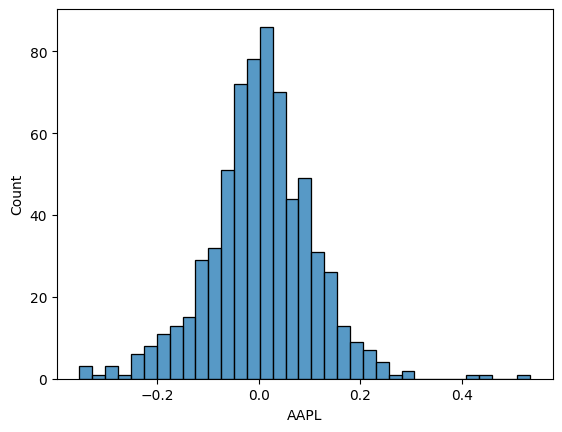

In [ ]:
sns.histplot(returnDf1d1_sc['AAPL'])

In [ ]:
returnDf1d1_sc.head(2)

symbol,A,AAL,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,...,CL=F,CNY=X,ES=F,EURUSD=X,GBPUSD=X,GC=F,JPY=X,NQ=F,YM=F,ZB=F
2021-05-27,0.191314,0.133055,-0.074262,-0.124499,0.374916,-0.054475,0.106181,-0.082410,-0.102963,0.000735,...,0.057997,-0.018066,0.008586,-0.027675,-0.011773,-0.017672,0.020294,-0.015219,0.027480,-0.028386
2021-05-28,0.025738,-0.046664,-0.032088,0.047009,-0.116086,0.049789,0.031754,0.045208,0.075861,0.051101,...,-0.047569,-0.008168,0.005001,0.000292,0.037243,0.021523,0.035120,0.009220,0.013242,0.013072


In [ ]:
returnDf1d1_sc.tail(2)

symbol,A,AAL,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,...,CL=F,CNY=X,ES=F,EURUSD=X,GBPUSD=X,GC=F,JPY=X,NQ=F,YM=F,ZB=F
2024-01-22,0.060814,-0.017570,0.072980,0.022577,0.089188,-0.026157,-0.030415,0.054575,-0.078096,0.078246,...,0.145484,-0.006662,0.014170,0.007254,-0.004724,-0.019837,-0.000284,0.006881,0.024287,0.035938
2024-01-23,-0.050472,0.213656,0.032183,0.054050,-0.024505,-0.003678,-0.000746,0.035620,-0.074994,0.082713,...,-0.065434,0.054368,0.006454,-0.024862,-0.009434,0.034459,0.009843,0.008764,-0.021362,-0.038830


In [ ]:
# Cut only sp500 tickers
numTickers = sprorDf.shape[1]
returnDf1d2_sc = returnDf1d1_sc.iloc[:, :numTickers]
returnDf1d2_sc.head(2)

symbol,A,AAL,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
2021-05-27,0.191314,0.133055,-0.074262,-0.124499,0.374916,-0.054475,0.106181,-0.082410,-0.102963,0.000735,...,0.009966,-0.061691,-0.038682,-0.037669,0.037994,0.005000,0.126081,-0.038657,0.121650,-0.022246
2021-05-28,0.025738,-0.046664,-0.032088,0.047009,-0.116086,0.049789,0.031754,0.045208,0.075861,0.051101,...,-0.036180,0.052084,-0.019468,0.039712,0.026531,-0.005995,0.025056,-0.012648,0.001036,0.069044


In [ ]:
# Prepare features for MLP
FeatureLaggedDf2 = prepareData_forMOLP(returnDf1d2_sc, explanatoryLag, printFlag=True)

== FeatureLaggedDf2: 
== Head index:
DatetimeIndex(['2021-06-24', '2021-06-25', '2021-06-28', '2021-06-29',
               '2021-06-30', '2021-07-01', '2021-07-02', '2021-07-06',
               '2021-07-07', '2021-07-08'],
              dtype='datetime64[ns]', freq=None)
== Tail index:
DatetimeIndex(['2024-01-09', '2024-01-10', '2024-01-11', '2024-01-12',
               '2024-01-16', '2024-01-17', '2024-01-18', '2024-01-19',
               '2024-01-22', '2024-01-23'],
              dtype='datetime64[ns]', freq=None)
Matrix dimension
(649, 10060)


In [ ]:
FeatureLaggedDf2

,A,A_1,A_2,A_3,A_4,A_5,A_6,A_7,A_8,A_9,...,ZTS_10,ZTS_11,ZTS_12,ZTS_13,ZTS_14,ZTS_15,ZTS_16,ZTS_17,ZTS_18,ZTS_19
2021-06-24,-0.023227,0.024960,0.009016,0.057927,-0.078002,0.139146,-0.042732,0.009557,0.035952,0.019712,...,0.183713,0.089259,-0.034267,-0.003424,0.047634,0.030183,-0.042711,-0.084560,0.069044,-0.022246
2021-06-25,0.024954,-0.023227,0.024960,0.009016,0.057927,-0.078002,0.139146,-0.042732,0.009557,0.035952,...,0.003294,0.183713,0.089259,-0.034267,-0.003424,0.047634,0.030183,-0.042711,-0.084560,0.069044
2021-06-28,0.026479,0.024954,-0.023227,0.024960,0.009016,0.057927,-0.078002,0.139146,-0.042732,0.009557,...,0.078375,0.003294,0.183713,0.089259,-0.034267,-0.003424,0.047634,0.030183,-0.042711,-0.084560
2021-06-29,0.035693,0.026479,0.024954,-0.023227,0.024960,0.009016,0.057927,-0.078002,0.139146,-0.042732,...,0.035432,0.078375,0.003294,0.183713,0.089259,-0.034267,-0.003424,0.047634,0.030183,-0.042711
2021-06-30,-0.040319,0.035693,0.026479,0.024954,-0.023227,0.024960,0.009016,0.057927,-0.078002,0.139146,...,-0.050411,0.035432,0.078375,0.003294,0.183713,0.089259,-0.034267,-0.003424,0.047634,0.030183
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-17,-0.110779,-0.000459,0.039790,-0.064536,0.018825,-0.121458,0.129596,-0.020153,-0.007319,-0.328216,...,-0.024319,0.006390,0.007923,0.042967,0.016002,0.009863,0.000925,-0.104503,0.041480,0.013144
2024-01-18,0.109585,-0.110779,-0.000459,0.039790,-0.064536,0.018825,-0.121458,0.129596,-0.020153,-0.007319,...,-0.111106,-0.024319,0.006390,0.007923,0.042967,0.016002,0.009863,0.000925,-0.104503,0.041480
2024-01-19,0.034953,0.109585,-0.110779,-0.000459,0.039790,-0.064536,0.018825,-0.121458,0.129596,-0.020153,...,0.034520,-0.111106,-0.024319,0.006390,0.007923,0.042967,0.016002,0.009863,0.000925,-0.104503
2024-01-22,0.060814,0.034953,0.109585,-0.110779,-0.000459,0.039790,-0.064536,0.018825,-0.121458,0.129596,...,0.025047,0.034520,-0.111106,-0.024319,0.006390,0.007923,0.042967,0.016002,0.009863,0.000925


In [ ]:
# Get lagged Df for ^GSPC
spscIndDf = returnDf1d1_sc[['^GSPC', '^DJI']]
spscIndDf

spscIndLaggedDf = prepareData_forMOLP(spscIndDf, explanatoryLag, printFlag=True)
spscIndLaggedDf

== FeatureLaggedDf2: 
== Head index:
DatetimeIndex(['2021-06-24', '2021-06-25', '2021-06-28', '2021-06-29',
               '2021-06-30', '2021-07-01', '2021-07-02', '2021-07-06',
               '2021-07-07', '2021-07-08'],
              dtype='datetime64[ns]', freq=None)
== Tail index:
DatetimeIndex(['2024-01-09', '2024-01-10', '2024-01-11', '2024-01-12',
               '2024-01-16', '2024-01-17', '2024-01-18', '2024-01-19',
               '2024-01-22', '2024-01-23'],
              dtype='datetime64[ns]', freq=None)
Matrix dimension
(649, 40)


,^GSPC,^GSPC_1,^GSPC_2,^GSPC_3,^GSPC_4,^GSPC_5,^GSPC_6,^GSPC_7,^GSPC_8,^GSPC_9,...,^DJI_10,^DJI_11,^DJI_12,^DJI_13,^DJI_14,^DJI_15,^DJI_16,^DJI_17,^DJI_18,^DJI_19
2021-06-24,0.034867,-0.006500,0.030747,0.084014,-0.078747,-0.002614,-0.032341,-0.012070,0.010891,0.011691,...,0.003326,-0.026476,-0.005270,-0.021778,0.031122,-0.004047,0.004351,0.007969,0.011283,0.024751
2021-06-25,0.019984,0.034867,-0.006500,0.030747,0.084014,-0.078747,-0.002614,-0.032341,-0.012070,0.010891,...,0.002326,0.003326,-0.026476,-0.005270,-0.021778,0.031122,-0.004047,0.004351,0.007969,0.011283
2021-06-28,0.013890,0.019984,0.034867,-0.006500,0.030747,0.084014,-0.078747,-0.002614,-0.032341,-0.012070,...,-0.014940,0.002326,0.003326,-0.026476,-0.005270,-0.021778,0.031122,-0.004047,0.004351,0.007969
2021-06-29,0.001664,0.013890,0.019984,0.034867,-0.006500,0.030747,0.084014,-0.078747,-0.002614,-0.032341,...,-0.016472,-0.014940,0.002326,0.003326,-0.026476,-0.005270,-0.021778,0.031122,-0.004047,0.004351
2021-06-30,0.007969,0.001664,0.013890,0.019984,0.034867,-0.006500,0.030747,0.084014,-0.078747,-0.002614,...,-0.046471,-0.016472,-0.014940,0.002326,0.003326,-0.026476,-0.005270,-0.021778,0.031122,-0.004047
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-17,-0.033701,-0.022388,0.004506,-0.004026,0.033996,-0.008867,0.084688,0.010954,-0.020570,-0.048098,...,0.004059,-0.003272,0.008537,0.017769,0.025575,-0.002949,0.052158,-0.076030,0.040514,0.000138
2024-01-18,0.052832,-0.033701,-0.022388,0.004506,-0.004026,0.033996,-0.008867,0.084688,0.010954,-0.020570,...,-0.045316,0.004059,-0.003272,0.008537,0.017769,0.025575,-0.002949,0.052158,-0.076030,0.040514
2024-01-19,0.073881,0.052832,-0.033701,-0.022388,0.004506,-0.004026,0.033996,-0.008867,0.084688,0.010954,...,0.001627,-0.045316,0.004059,-0.003272,0.008537,0.017769,0.025575,-0.002949,0.052158,-0.076030
2024-01-22,0.013166,0.073881,0.052832,-0.033701,-0.022388,0.004506,-0.004026,0.033996,-0.008867,0.084688,...,0.004130,0.001627,-0.045316,0.004059,-0.003272,0.008537,0.017769,0.025575,-0.002949,0.052158


#### Transform into per-ticker DF

In [ ]:
# Transform at day = 0
i = 0
datename = datetime.strftime(FeatureLaggedDf2.index[i], '%Y-%m-%d') + '_'
print(datename)
tickernames = returnDf1d2_sc.columns
# comprehension
newRownames = [datename + e for e in tickernames]

row0 = FeatureLaggedDf2.iloc[i,:]
newArr = row0.values.reshape((returnDf1d2_sc.shape[1], explanatoryLag + 1))

# concatenate one tick TS and SP-index TS
onedayArr = newArr

# column names
tickerlagname = [str(e) for e in np.arange(explanatoryLag + 1)]

# one day df
df0 = pd.DataFrame(onedayArr, index=newRownames, columns=tickerlagname)

FeatureLaggedDf3 = df0
FeatureLaggedDf3

2021-06-24_


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
2021-06-24_A,-0.023227,0.024960,0.009016,0.057927,-0.078002,0.139146,-0.042732,0.009557,0.035952,0.019712,0.125456,0.059674,0.047948,-0.010877,0.067317,-0.008786,-0.027550,-0.040397,0.025738,0.191314
2021-06-24_AAL,0.040540,0.024423,-0.090869,0.043069,0.016195,-0.157687,0.010531,-0.052196,-0.137697,0.017903,-0.098114,-0.091660,-0.007423,-0.012345,-0.151625,-0.206816,0.279692,0.106436,-0.046664,0.133055
2021-06-24_AAPL,-0.013013,-0.012541,0.076190,0.084625,-0.060551,0.075606,0.023603,-0.038625,0.147466,0.058996,-0.048140,0.018462,0.040032,0.000477,0.114133,-0.072925,0.037658,-0.015890,-0.032088,-0.074262
2021-06-24_ABBV,0.038947,-0.036617,-0.001570,0.085396,-0.092950,-0.032719,-0.015540,0.022357,-0.001039,-0.042326,0.117894,0.088660,-0.035573,0.034710,0.008021,0.043627,-0.043312,-0.052473,0.047009,-0.124499
2021-06-24_ABNB,-0.033646,0.076163,-0.000802,-0.110937,0.072462,0.062353,-0.103966,0.103344,0.031124,0.095264,0.052606,-0.088157,-0.078942,-0.070059,0.272141,-0.270596,0.278151,0.167094,-0.116086,0.374916
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-24_YUM,0.002565,-0.028596,0.038028,0.110956,-0.112975,-0.066024,-0.021760,0.025920,-0.079733,0.047511,0.060239,-0.077103,0.037526,-0.022732,0.002526,-0.026165,-0.033028,-0.003501,-0.005995,0.005000
2021-06-24_ZBH,-0.002918,-0.068879,0.106434,0.188128,-0.070328,0.089602,-0.011746,0.030086,-0.027673,-0.036920,0.039438,0.025898,-0.013679,-0.046377,-0.030388,-0.041722,-0.186260,-0.075209,0.025056,0.126081
2021-06-24_ZBRA,0.089604,-0.042177,0.027493,0.130110,-0.103487,-0.054589,0.007113,-0.044948,0.016992,-0.001769,0.038943,-0.002611,-0.007230,-0.120681,0.124852,0.015096,0.022071,0.070858,-0.012648,-0.038657
2021-06-24_ZION,0.120814,0.036350,0.015945,0.283897,-0.153429,-0.382007,0.067131,0.055535,-0.135697,0.020696,-0.163193,-0.122492,-0.001037,-0.033029,-0.016470,0.011344,0.005161,0.025916,0.001036,0.121650


In [ ]:
# Transform FeatureLaggedDf2 into FeatureLaggedDf3 by splitting per ticker and stacking them
# MLP input is 20-features of daily lagged returns (lag=0-19) for a stock on a day
for i in tqdm(range(1, len(FeatureLaggedDf2))):

    datename = datetime.strftime(FeatureLaggedDf2.index[i], '%Y-%m-%d') + '_'
    #print(datename)
    tickernames = returnDf1d2_sc.columns

    # comprehension
    newRownames = [datename + e for e in tickernames]

    row0 = FeatureLaggedDf2.iloc[i,:]
    newArr = row0.values.reshape((returnDf1d2_sc.shape[1], explanatoryLag + 1))

    # concatenate one tick TS and SP-index TS
    onedayArr = newArr

    # column names
    tickerlagname = [str(e) for e in np.arange(explanatoryLag + 1)]

    # one day df
    df0 = pd.DataFrame(onedayArr, index=newRownames, columns=tickerlagname )

    FeatureLaggedDf3 = pd.concat([FeatureLaggedDf3, df0], axis=0)


100%|██████████| 648/648 [00:08<00:00, 75.33it/s]


In [ ]:
FeatureLaggedDf3.iloc[499:509,:]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
2021-06-24_ZBH,-0.002918,-0.068879,0.106434,0.188128,-0.070328,0.089602,-0.011746,0.030086,-0.027673,-0.036920,0.039438,0.025898,-0.013679,-0.046377,-0.030388,-0.041722,-0.186260,-0.075209,0.025056,0.126081
2021-06-24_ZBRA,0.089604,-0.042177,0.027493,0.130110,-0.103487,-0.054589,0.007113,-0.044948,0.016992,-0.001769,0.038943,-0.002611,-0.007230,-0.120681,0.124852,0.015096,0.022071,0.070858,-0.012648,-0.038657
2021-06-24_ZION,0.120814,0.036350,0.015945,0.283897,-0.153429,-0.382007,0.067131,0.055535,-0.135697,0.020696,-0.163193,-0.122492,-0.001037,-0.033029,-0.016470,0.011344,0.005161,0.025916,0.001036,0.121650
2021-06-24_ZTS,-0.023856,-0.016074,0.000642,0.039161,-0.033792,0.075933,-0.050411,0.035432,0.078375,0.003294,0.183713,0.089259,-0.034267,-0.003424,0.047634,0.030183,-0.042711,-0.084560,0.069044,-0.022246
2021-06-25_A,0.024954,-0.023227,0.024960,0.009016,0.057927,-0.078002,0.139146,-0.042732,0.009557,0.035952,0.019712,0.125456,0.059674,0.047948,-0.010877,0.067317,-0.008786,-0.027550,-0.040397,0.025738
2021-06-25_AAL,-0.034900,0.040540,0.024423,-0.090869,0.043069,0.016195,-0.157687,0.010531,-0.052196,-0.137697,0.017903,-0.098114,-0.091660,-0.007423,-0.012345,-0.151625,-0.206816,0.279692,0.106436,-0.046664
2021-06-25_AAPL,-0.013491,-0.013013,-0.012541,0.076190,0.084625,-0.060551,0.075606,0.023603,-0.038625,0.147466,0.058996,-0.048140,0.018462,0.040032,0.000477,0.114133,-0.072925,0.037658,-0.015890,-0.032088
2021-06-25_ABBV,-0.092034,0.038947,-0.036617,-0.001570,0.085396,-0.092950,-0.032719,-0.015540,0.022357,-0.001039,-0.042326,0.117894,0.088660,-0.035573,0.034710,0.008021,0.043627,-0.043312,-0.052473,0.047009
2021-06-25_ABNB,-0.042195,-0.033646,0.076163,-0.000802,-0.110937,0.072462,0.062353,-0.103966,0.103344,0.031124,0.095264,0.052606,-0.088157,-0.078942,-0.070059,0.272141,-0.270596,0.278151,0.167094,-0.116086
2021-06-25_ABT,0.054790,0.046554,-0.006490,-0.025843,0.060364,-0.069873,0.085589,-0.019020,-0.003802,0.031116,-0.013072,0.060523,0.063947,-0.114545,0.038979,0.004944,0.129093,0.062954,-0.558595,0.049789


In [ ]:
FeatureLaggedDf3

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
2021-06-24_A,-0.023227,0.024960,0.009016,0.057927,-0.078002,0.139146,-0.042732,0.009557,0.035952,0.019712,0.125456,0.059674,0.047948,-0.010877,0.067317,-0.008786,-0.027550,-0.040397,0.025738,0.191314
2021-06-24_AAL,0.040540,0.024423,-0.090869,0.043069,0.016195,-0.157687,0.010531,-0.052196,-0.137697,0.017903,-0.098114,-0.091660,-0.007423,-0.012345,-0.151625,-0.206816,0.279692,0.106436,-0.046664,0.133055
2021-06-24_AAPL,-0.013013,-0.012541,0.076190,0.084625,-0.060551,0.075606,0.023603,-0.038625,0.147466,0.058996,-0.048140,0.018462,0.040032,0.000477,0.114133,-0.072925,0.037658,-0.015890,-0.032088,-0.074262
2021-06-24_ABBV,0.038947,-0.036617,-0.001570,0.085396,-0.092950,-0.032719,-0.015540,0.022357,-0.001039,-0.042326,0.117894,0.088660,-0.035573,0.034710,0.008021,0.043627,-0.043312,-0.052473,0.047009,-0.124499
2021-06-24_ABNB,-0.033646,0.076163,-0.000802,-0.110937,0.072462,0.062353,-0.103966,0.103344,0.031124,0.095264,0.052606,-0.088157,-0.078942,-0.070059,0.272141,-0.270596,0.278151,0.167094,-0.116086,0.374916
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-23_YUM,0.023349,-0.056236,0.084623,0.064146,-0.033741,0.031596,0.006047,-0.009288,0.045858,-0.019589,0.014025,-0.016319,-0.019055,0.003255,-0.074851,0.006436,-0.014674,0.026716,0.012000,0.000923
2024-01-23_ZBH,-0.059222,-0.037452,-0.022773,0.078540,-0.020059,-0.020964,0.033829,-0.041386,0.066957,-0.004919,0.099516,-0.010981,-0.013448,-0.045473,-0.015283,0.003453,0.024767,-0.014330,0.054854,0.045633
2024-01-23_ZBRA,0.035589,0.132001,-0.012020,0.261404,-0.107178,-0.128983,-0.144924,-0.005641,-0.027375,-0.106860,0.199454,-0.006641,0.010692,-0.346145,-0.117440,-0.044017,-0.009573,0.006316,0.135630,0.092722
2024-01-23_ZION,-0.036020,0.243633,0.162882,-0.061553,-0.032070,-0.135360,-0.170281,-0.080583,-0.014986,-0.067355,0.066743,0.198405,0.091428,-0.290893,0.036927,-0.106135,0.020220,-0.049466,0.120000,0.052270


In [ ]:
# Check dimension of FeatureLaggedDf3
print( (returnDf1d2_sc.shape[0] - explanatoryLag) * returnDf1d2_sc.shape[1] )

326447


### Prepare responses (ranks of 5d-returns)

In [ ]:
# Make an initial input DF
print(spRankClassDf.iloc[:4, :10])
spRankClassDf1 = spRankClassDf.tail(testLength + (predLag - 1) + trainLength + explanatoryLag + predLag)
spRankClassDf1

symbol      A  AAL  AAPL  ABBV  ABNB  ABT  ACGL  ACN  ADBE  ADI
2021-01-04  1    0     0     1     0    0     0    0     0    0
2021-01-05  0    0     0     1     0    1     0    0     0    1
2021-01-06  0    0     0     0     0    0     0    0     0    0
2021-01-07  1    0     0     0     0    0     0    0     0    0


symbol,A,AAL,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
2021-05-27,1,1,0,0,1,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0
2021-05-28,1,1,0,0,1,0,0,0,1,1,...,1,0,0,0,0,0,0,0,0,0
2021-06-01,1,1,0,0,1,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0
2021-06-02,0,1,0,0,1,0,0,0,0,0,...,1,0,1,0,0,0,0,0,1,0
2021-06-03,0,1,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-17,0,0,0,0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
2024-01-18,0,0,1,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2024-01-19,0,0,1,0,0,0,1,1,1,1,...,0,0,0,0,0,1,0,0,0,0
2024-01-22,0,1,1,0,1,0,1,1,0,1,...,0,0,0,0,0,0,0,0,1,0


In [ ]:
# Responses for sequential predictions
# ResponseDf2 nrow      = trainLength + testLength + (predLag - 1)            (to simulate h-day ahead prediction)
ResponseDf2 = spRankClassDf1.iloc[(explanatoryLag + predLag):, :]
print("== ResponseDf2: ")
print(ResponseDf2.head(10).index)
print(ResponseDf2.tail(10).index)
print(ResponseDf2.shape)

== ResponseDf2: 
DatetimeIndex(['2021-07-01', '2021-07-02', '2021-07-06', '2021-07-07',
               '2021-07-08', '2021-07-09', '2021-07-12', '2021-07-13',
               '2021-07-14', '2021-07-15'],
              dtype='datetime64[ns]', freq=None)
DatetimeIndex(['2024-01-09', '2024-01-10', '2024-01-11', '2024-01-12',
               '2024-01-16', '2024-01-17', '2024-01-18', '2024-01-19',
               '2024-01-22', '2024-01-23'],
              dtype='datetime64[ns]', freq=None)
(644, 503)


In [ ]:
ResponseDf2

symbol,A,AAL,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
2021-07-01,0,0,1,0,0,1,1,1,0,0,...,0,0,0,0,1,0,0,1,0,0
2021-07-02,0,0,1,0,0,1,0,1,0,0,...,0,0,0,0,1,0,0,1,0,1
2021-07-06,0,0,1,1,0,1,0,1,0,0,...,0,0,0,0,0,0,0,1,0,1
2021-07-07,0,0,1,1,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,1
2021-07-08,0,0,1,1,0,1,0,1,1,0,...,0,1,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-17,0,0,0,0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
2024-01-18,0,0,1,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2024-01-19,0,0,1,0,0,0,1,1,1,1,...,0,0,0,0,0,1,0,0,0,0
2024-01-22,0,1,1,0,1,0,1,1,0,1,...,0,0,0,0,0,0,0,0,1,0


#### Transform into per-ticker DF

In [ ]:
# pd series
i = 0
datename = datetime.strftime(ResponseDf2.index[i], '%Y-%m-%d') + '_'
print(datename)
tickernames = ResponseDf2.columns
# comprehension
newRownames = [datename + e for e in tickernames]

row0 = ResponseDf2.iloc[i,:]
newArr = row0.values.reshape((ResponseDf2.shape[1], ))

# one day df
df0 = pd.Series(newArr, index=newRownames, name='rankClass')

ResponseDf3 = df0
ResponseDf3

2021-07-01_


,rankClass
2021-07-01_A,0
2021-07-01_AAL,0
2021-07-01_AAPL,1
2021-07-01_ABBV,0
2021-07-01_ABNB,0
...,...
2021-07-01_YUM,0
2021-07-01_ZBH,0
2021-07-01_ZBRA,1
2021-07-01_ZION,0


In [ ]:
# ResponseDf2 => make linearized
for i in tqdm(range(1, len(ResponseDf2))):
#for i in tqdm(range(1, 10)):

    datename = datetime.strftime(ResponseDf2.index[i], '%Y-%m-%d') + '_'
    #print(datename)
    tickernames = ResponseDf2.columns

    # comprehension
    newRownames = [datename + e for e in tickernames]

    row0 = ResponseDf2.iloc[i,:]
    newArr = row0.values.reshape((ResponseDf2.shape[1], ))

    # one day df
    df0 = pd.Series(newArr, index=newRownames)

    ResponseDf3 = pd.concat([ResponseDf3, df0], axis=0)


100%|██████████| 643/643 [00:01<00:00, 487.04it/s]


In [ ]:
ResponseDf3.iloc[499:509]

,0
2021-07-01_ZBH,0
2021-07-01_ZBRA,1
2021-07-01_ZION,0
2021-07-01_ZTS,0
2021-07-02_A,0
2021-07-02_AAL,0
2021-07-02_AAPL,1
2021-07-02_ABBV,0
2021-07-02_ABNB,0
2021-07-02_ABT,1


In [ ]:
ResponseDf3

,0
2021-07-01_A,0
2021-07-01_AAL,0
2021-07-01_AAPL,1
2021-07-01_ABBV,0
2021-07-01_ABNB,0
...,...
2024-01-23_YUM,0
2024-01-23_ZBH,0
2024-01-23_ZBRA,1
2024-01-23_ZION,1


In [ ]:
# Check dimension of ResponseDf3
print( ResponseDf2.shape[0] * ResponseDf2.shape[1] )

323932


## One cycle of training and h-day-ahead prediction

### Train/test matrixes parameters

In [ ]:
# Input: FeatureLaggedDf3, ResponseDf3
seqid = 0
nrowsOneday = ResponseDf2.shape[1]
ncolLagged = FeatureLaggedDf3.shape[1]
ncolResponse = 1

In [ ]:
# Target variable values of the test dataset during testLength days
# Y_seqtest df
seqTestRow = trainLength + (predLag - 1)            # h-day future
seqTestRows2 = np.arange(seqTestRow, seqTestRow + testLength)
print(seqTestRows2)
Y_seqtest_Df = ResponseDf2.iloc[seqTestRows2, :]
Y_seqtest_Df

[604 605 606 607 608 609 610 611 612 613 614 615 616 617 618 619 620 621
 622 623 624 625 626 627 628 629 630 631 632 633 634 635 636 637 638 639
 640 641 642 643]


symbol,A,AAL,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
2023-11-24,1,0,0,0,0,0,1,0,1,0,...,1,0,0,1,0,0,0,1,0,0
2023-11-27,1,0,0,0,0,1,1,0,1,0,...,0,0,0,1,1,0,0,1,0,1
2023-11-28,1,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,0,0,1,0,0
2023-11-29,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
2023-11-30,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,1,0
2023-12-01,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
2023-12-04,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2023-12-05,0,1,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2023-12-06,0,1,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2023-12-07,0,1,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [ ]:
# Check data matrix

X_train, y_train, X_test, y_test, yDf_tr, yDf_te = set_train_test_matrix_for_periodPrediction(FeatureLaggedDf3, ResponseDf3, nrowsOneday, trainLength, predLag, testLength)


== ResponseDf3 
2021-07-01_A       0
2021-07-01_AAL     0
2021-07-01_AAPL    1
2021-07-01_ABBV    0
2021-07-01_ABNB    0
2021-07-01_ABT     1
dtype: int64
2024-01-23_XYL     0
2024-01-23_YUM     0
2024-01-23_ZBH     0
2024-01-23_ZBRA    1
2024-01-23_ZION    1
2024-01-23_ZTS     0
dtype: int64
== FeatureLaggedDf3_tr: 
Index(['2021-06-24_A', '2021-06-24_AAL', '2021-06-24_AAPL', '2021-06-24_ABBV'], dtype='object')
Index(['2023-11-09_ZBH', '2023-11-09_ZBRA', '2023-11-09_ZION',
       '2023-11-09_ZTS'],
      dtype='object')
== FeatureLaggedDf3_te: 
Index(['2023-11-16_A', '2023-11-16_AAL', '2023-11-16_AAPL', '2023-11-16_ABBV'], dtype='object')
Index(['2024-01-16_ZBH', '2024-01-16_ZBRA', '2024-01-16_ZION',
       '2024-01-16_ZTS'],
      dtype='object')
== yDf_tr: 
Index(['2021-07-01_A', '2021-07-01_AAL', '2021-07-01_AAPL', '2021-07-01_ABBV'], dtype='object')
Index(['2023-11-16_ZBH', '2023-11-16_ZBRA', '2023-11-16_ZION',
       '2023-11-16_ZTS'],
      dtype='object')
== yDf_te: 
Index(['202

### Specify a MLP model

In [ ]:
# Number of columns of train/test matrixes
ncolLagged_half = round(ncolLagged/2)
print(ncolLagged_half)
ncolLagged_quarter = round(ncolLagged/4)
print(ncolLagged_quarter)
print(ncolResponse)

10
5
1


In [ ]:
# Build a model specification or a list of them
specList = list()
#DO_list = [0.0, 0.1, 0.2]
DO_list = [0.2]

for j in DO_list:
    specList.append( [ncolLagged, [80, 320, 80], [0,0,1], ncolResponse, 'relu', 'sigmoid', j] )

specList

[[20, [80, 320, 80], [0, 0, 1], 1, 'relu', 'sigmoid', 0.2]]

In [ ]:
# Clear up GPU RAM
#from numba import cuda
#cuda.select_device(0)
#cuda.close()

In [ ]:
# Build a model
# MLP_specifier(inputlsize, layerSizeVec, dropOutIndicVec, outputlsize, activationFtnName, outputActivationFtnName, dropoutRate = 0.0)
tmpMod = MLP_specifier(*specList[0])
tmpMod.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 80)             │         1,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 320)            │        25,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 80)             │        25,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 80)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            81 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 53,361 (208.44 KB)

 Trainable params: 53,361 (208.44 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Number of parameters of a network
#MLPs[-1].summary()

In [ ]:
# Str for a model specification
modelStr = "-".join(str(e) for e in specList[0])
print(modelStr)
fname = 'forPred_' + modelStr + '.txt'; print(fname)
#with open(os.path.join(outputPath, fname), 'w') as f:
#    f.write(modelStr)

20-[80, 320, 80]-[0, 0, 1]-1-relu-sigmoid-0.2
forPred_20-[80, 320, 80]-[0, 0, 1]-1-relu-sigmoid-0.2.txt


### Train MLP and predict for test data

In [ ]:
#
#Y_te_pred_mat = np.zeros((testLength, nrowsOneday))
#Y_te_pred_mat.shape


#### Train the model

    
==== 
20-[80, 320, 80]-[0, 0, 1]-1-relu-sigmoid-0.2
====
==== Validation Size in days :60
Epoch 1/10
4245/4245 - 15s - 4ms/step - binary_accuracy: 0.8012 - loss: 0.4972 - val_binary_accuracy: 0.8012 - val_loss: 0.5053
Epoch 2/10
4245/4245 - 18s - 4ms/step - binary_accuracy: 0.8012 - loss: 0.4943 - val_binary_accuracy: 0.8012 - val_loss: 0.4961
Epoch 3/10
4245/4245 - 10s - 2ms/step - binary_accuracy: 0.8013 - loss: 0.4930 - val_binary_accuracy: 0.8012 - val_loss: 0.4959
Epoch 4/10
4245/4245 - 11s - 3ms/step - binary_accuracy: 0.8015 - loss: 0.4920 - val_binary_accuracy: 0.8012 - val_loss: 0.4971
Epoch 5/10
4245/4245 - 11s - 3ms/step - binary_accuracy: 0.8019 - loss: 0.4910 - val_binary_accuracy: 0.8012 - val_loss: 0.4973
Epoch 6/10
4245/4245 - 20s - 5ms/step - binary_accuracy: 0.8021 - loss: 0.4900 - val_binary_accuracy: 0.8010 - val_loss: 0.4998
Epoch 7/10
4245/4245 - 10s - 2ms/step - binary_accuracy: 0.8026 - loss: 0.4890 - val_binary_accuracy: 0.8012 - val_loss: 0.4971
Epoch 8/1

(<Figure size 1000x500 with 2 Axes>,
 array([<Axes: title={'center': 'Binary Accuracy'}, xlabel='Epochs', ylabel='Binary Accuracy'>,
        <Axes: title={'center': 'Loss'}, xlabel='Epochs', ylabel='Loss'>],
       dtype=object))

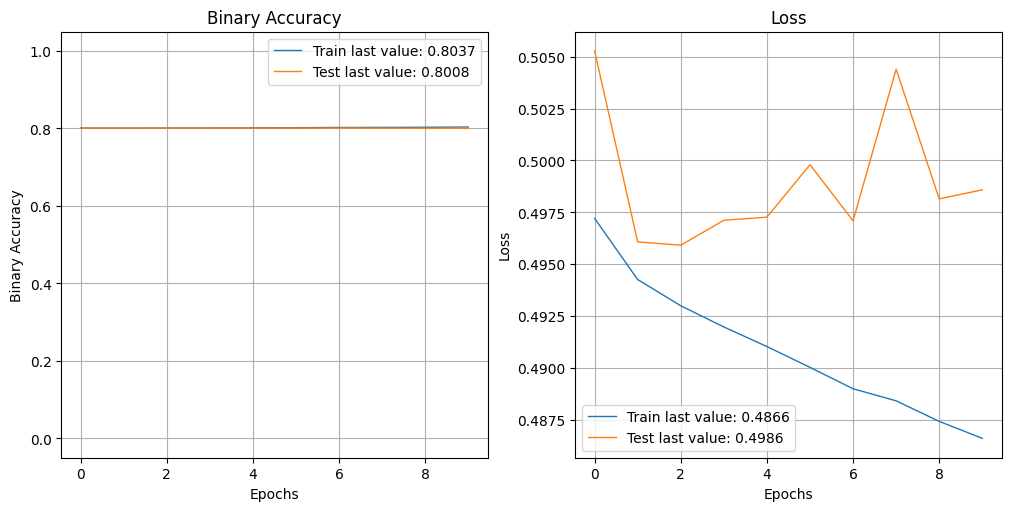

In [ ]:
# Run model list

print('    ')
print('==== ')
modelStr = "-".join(str(e) for e in specList[0])
print(modelStr)
print('====')

# To limit memory usage
MLPs_i = MLP_specifier(*specList[0])

T0 = process_time()
MLPs_i.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-3),
              #optimizer=tf.keras.optimizers.Nadam(learning_rate=1e-3),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              #tf.keras.losses.CategoricalCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(),
                      #tf.keras.metrics.BinaryIoU(),
                      ])

valSize = round(trainLength * 0.1)
print('==== Validation Size in days :' + str(valSize))

history1 = MLPs_i.fit(x=X_train[(valSize*nrowsOneday):,:], y=y_train[(valSize*nrowsOneday):],
                    validation_data=( X_train[:(valSize*nrowsOneday),:], y_train[:(valSize*nrowsOneday)] ),
                    shuffle=True,
                    epochs=10,
                    batch_size=64,
                    verbose=2)
T1 = process_time()
print("Proc time: ", T1-T0, 'sec')

#
trloss = np.round(history1.history.get('loss')[-1], 3)
valloss = np.round(history1.history.get('val_loss')[-1], 3)
modelStr1 = modelStr + '-' + str(trloss) + '-' + str(valloss)
print(modelStr1)

plot_history(history1)

#### Fitting performance in the training data

In the training data, let us assess the class prediction performance per day.

First consider top-10 tickers with the highest prediction probabilites on each day, and compute the number of hits among the top-10 predicted ones on each day.
If the predition is random, the expected number of hits will be 2 because the
target indicator is the top-100 performers among S&P500.

**Below, the average of the numbers of hits is greater than 2. This indicates the predicted probabilities are not random at least.**

In [ ]:
# Fit the entire training data
y_tr_predicted = MLPs_i.predict(X_train)
print(y_tr_predicted.shape)

Y_tr_predicted = y_tr_predicted.reshape((trainLength, nrowsOneday))
print(Y_tr_predicted.shape)
YDf_tr = yDf_tr.values.reshape((trainLength, nrowsOneday))
print(YDf_tr.shape)

9432/9432 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step
(301800, 1)
(600, 503)
(600, 503)


In [ ]:
# Range of predicted probabilities
print(Y_tr_predicted.max())
print(Y_tr_predicted.min())

0.9998386
0.015906652


<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


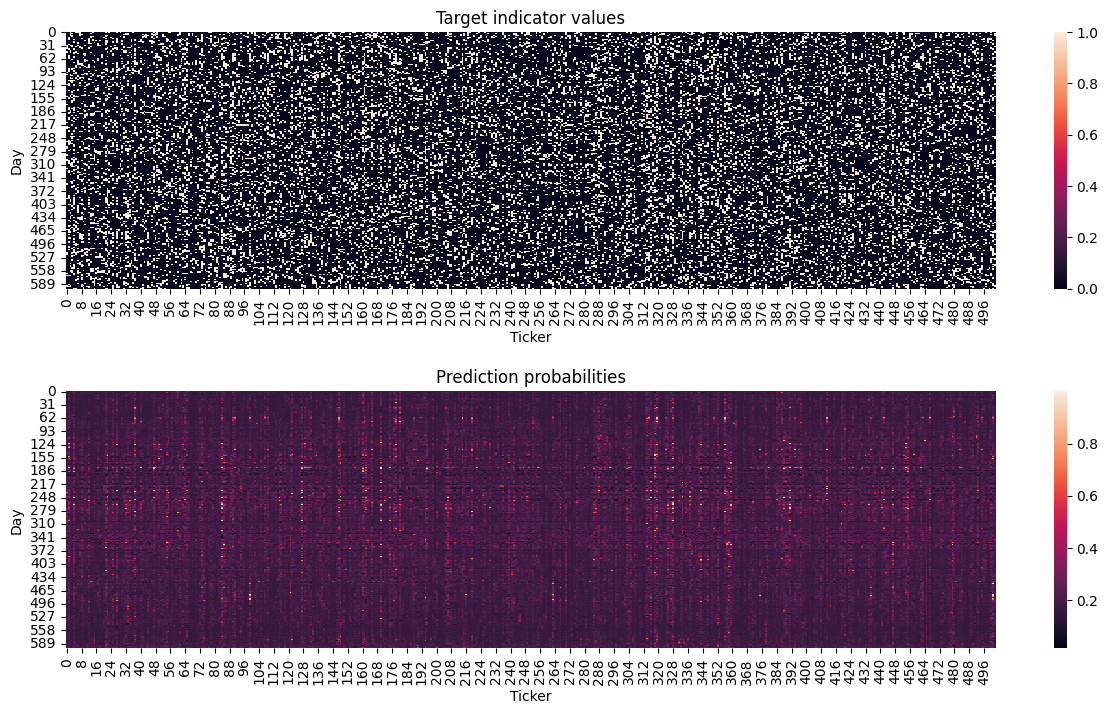

In [ ]:
# Visualize y's
print(type(YDf_tr))
print(type(Y_tr_predicted))
fig1, (ax1, ax2) = plt.subplots(2, 1, figsize=(15,8))
sns.heatmap(YDf_tr, ax=ax1, vmin=0, vmax=1)
ax1.set_xlabel('Ticker')
ax1.set_ylabel('Day')
ax1.set_title('Target indicator values')
sns.heatmap(Y_tr_predicted, ax=ax2)
ax2.set_xlabel('Ticker')
ax2.set_ylabel('Day')
ax2.set_title('Prediction probabilities')
plt.subplots_adjust(hspace=0.4)

== Model ==
20-[80, 320, 80]-[0, 0, 1]-1-relu-sigmoid-0.2
== The number of hits on each day ==
[1, 2, 1, 0, 2, 2, 1, 2, 2, 4, 1, 0, 1, 2, 3, 4, 8, 5, 2, 1, 1, 4, 2, 6, 4, 4, 3, 3, 0, 2, 2, 1, 0, 1, 1, 1, 2, 6, 4, 6, 5, 4, 4, 3, 0, 0, 2, 2, 1, 1, 4, 2, 5, 5, 3, 3, 3, 4, 5, 4, 10, 10, 10, 8, 10, 9, 8, 9, 10, 7, 8, 6, 7, 7, 5, 4, 4, 6, 3, 4, 5, 2, 4, 3, 6, 3, 3, 2, 3, 2, 5, 7, 2, 4, 3, 2, 7, 4, 3, 3, 7, 4, 3, 5, 4, 2, 3, 1, 1, 6, 2, 6, 1, 8, 5, 2, 2, 1, 4, 4, 5, 10, 10, 10, 9, 3, 5, 1, 5, 4, 2, 1, 6, 7, 3, 9, 7, 6, 6, 5, 2, 0, 2, 1, 3, 4, 6, 6, 10, 9, 6, 7, 10, 3, 4, 8, 8, 2, 7, 1, 1, 0, 4, 3, 1, 5, 8, 4, 7, 5, 3, 5, 4, 2, 7, 3, 9, 8, 8, 5, 7, 10, 9, 7, 7, 7, 7, 9, 4, 2, 5, 5, 4, 4, 5, 4, 1, 3, 4, 7, 3, 6, 5, 0, 1, 2, 2, 1, 5, 4, 4, 5, 7, 5, 7, 3, 2, 1, 3, 3, 9, 8, 9, 7, 3, 4, 5, 7, 1, 5, 7, 9, 9, 6, 8, 4, 6, 5, 7, 7, 3, 5, 3, 4, 3, 6, 3, 7, 3, 4, 2, 1, 6, 5, 8, 10, 7, 7, 8, 7, 8, 4, 9, 10, 10, 10, 8, 5, 4, 1, 3, 3, 1, 10, 7, 10, 7, 6, 6, 6, 10, 8, 5, 8, 3, 1, 1, 4, 6, 10, 8, 8, 5, 5, 3, 

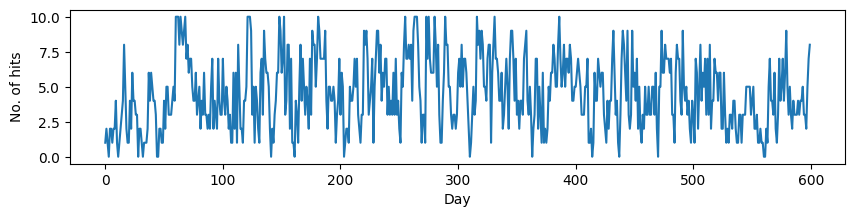

== Average of the daily numbers of hits ==
4.6


In [ ]:
# Compute the number of hits among the top-10 predicted ones on each day.
numIntersect = []
for r in range(trainLength):
    yser = YDf_tr[r, :]
    idx = np.nonzero(np.array(yser))
    idxs = np.sort(idx)

    predser = pd.Series(Y_tr_predicted[r, :])
    ranks = predser.rank(ascending=False)
    idx2 = np.nonzero(np.array(ranks <= 10))
    idx2s = np.sort(idx2)
    set_intersect = set(list(idxs[0])) & set(list(idx2s[0]))
    numIntersect.append(len(set_intersect))

print("== Model ==")
print(modelStr)
print("== The number of hits on each day ==")
print(numIntersect)
fig1 = plt.figure(figsize=(10,2))
plt.plot(numIntersect);
plt.xlabel('Day')
plt.ylabel('No. of hits')
plt.show()

tr_intSc = np.round(np.array(numIntersect).mean(), 1)
print("== Average of the daily numbers of hits ==")
print(tr_intSc)

#### Prediction performance in the test data

Let's assess the class prediction performance per day in the test data as before.

Again, if the predition is random, the expected number of hits among the top-10 predicted will be around 2 because the target indicator is the top-100 performers among S&P500.

**Below, the average of the numbers of hits during 40-days of testing is greater than 2. This indicates the MLP prediction is at least better than random in the test data.**

In [ ]:
# Testing period
Y_seqtest_Df.index

DatetimeIndex(['2023-11-24', '2023-11-27', '2023-11-28', '2023-11-29',
               '2023-11-30', '2023-12-01', '2023-12-04', '2023-12-05',
               '2023-12-06', '2023-12-07', '2023-12-08', '2023-12-11',
               '2023-12-12', '2023-12-13', '2023-12-14', '2023-12-15',
               '2023-12-18', '2023-12-19', '2023-12-20', '2023-12-21',
               '2023-12-22', '2023-12-26', '2023-12-27', '2023-12-28',
               '2023-12-29', '2024-01-02', '2024-01-03', '2024-01-04',
               '2024-01-05', '2024-01-08', '2024-01-09', '2024-01-10',
               '2024-01-11', '2024-01-12', '2024-01-16', '2024-01-17',
               '2024-01-18', '2024-01-19', '2024-01-22', '2024-01-23'],
              dtype='datetime64[ns]', freq=None)

In [ ]:
# Predict the test data
y_te_predicted = MLPs_i.predict(X_test)
print(y_te_predicted.shape)

Y_te_predicted = y_te_predicted.reshape((testLength, nrowsOneday))
print(Y_te_predicted.shape)

YDf_te = yDf_te.values.reshape((testLength, nrowsOneday))
print(YDf_te.shape)

629/629 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(20120, 1)
(40, 503)
(40, 503)


In [ ]:
# Range of predicted probabilities
print(Y_te_predicted.max())
print(Y_te_predicted.min())

0.96237576
0.06361994


<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


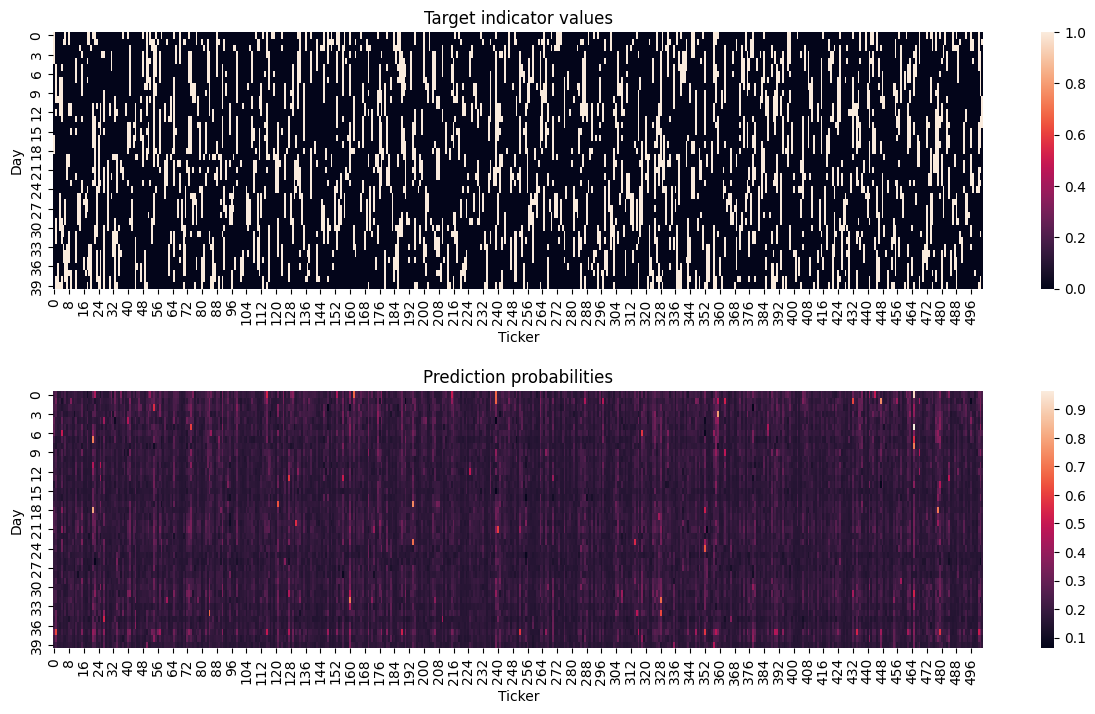

In [ ]:
# Visualize y's in test data
print(type(YDf_te))
print(type(Y_te_predicted))
fig1, (ax1, ax2) = plt.subplots(2, 1, figsize=(15,8))
sns.heatmap(YDf_te, ax=ax1, vmin=0, vmax=1)
ax1.set_xlabel('Ticker')
ax1.set_ylabel('Day')
ax1.set_title('Target indicator values')
sns.heatmap(Y_te_predicted, ax=ax2)
ax2.set_xlabel('Ticker')
ax2.set_ylabel('Day')
ax2.set_title('Prediction probabilities')
plt.subplots_adjust(hspace=0.4)

== Model ==
20-[80, 320, 80]-[0, 0, 1]-1-relu-sigmoid-0.2
== The number of hits on each day ==
[5, 1, 1, 5, 0, 6, 4, 2, 4, 9, 6, 4, 3, 7, 7, 4, 5, 2, 4, 5, 2, 6, 0, 5, 1, 1, 3, 1, 2, 2, 0, 3, 3, 1, 2, 2, 2, 1, 1, 5]


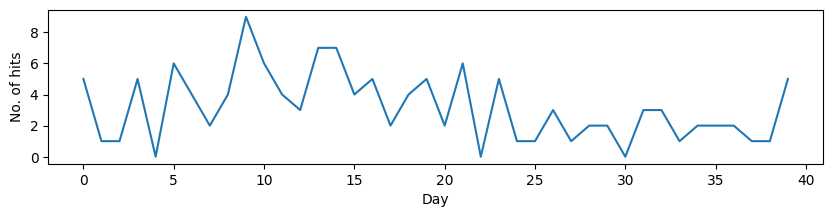

== Average of the daily numbers of hits ==
3.2


In [ ]:
# Compute the number of hits among the top-10 predicted ones on each day.
numIntersect = []
for r in range(testLength):
    yser = YDf_te[r, :]
    idx = np.nonzero(np.array(yser))
    idxs = np.sort(idx)

    predser = pd.Series(Y_te_predicted[r, :])
    ranks = predser.rank(ascending=False)
    idx2 = np.nonzero(np.array(ranks <= 10))
    idx2s = np.sort(idx2)
    set_intersect = set(list(idxs[0])) & set(list(idx2s[0]))
    numIntersect.append(len(set_intersect))

print("== Model ==")
print(modelStr)
print("== The number of hits on each day ==")
print(numIntersect)
fig1 = plt.figure(figsize=(10,2))
plt.plot(numIntersect);
plt.xlabel('Day')
plt.ylabel('No. of hits')
plt.show()

tr_intSc = np.round(np.array(numIntersect).mean(), 1)
print("== Average of the daily numbers of hits ==")
print(tr_intSc)

In [ ]:
# Prediction outcome for the latest day
# Prediction probabilities
busi_5d_us = pd.offsets.CustomBusinessDay(n=5, calendar=USFederalHolidayCalendar())
date_5dlater = datetime.strftime(ResponseDf2.index[-1] + busi_5d_us, "%Y-%m-%d")
Y_te_seqPred_Df = pd.DataFrame(Y_te_predicted[-1,:].reshape((1, nrowsOneday)), index=[Y_seqtest_Df.index[-1]], columns=Y_seqtest_Df.columns)
Y_te_seqPred_Df

symbol,A,AAL,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
2024-01-23,0.178109,0.216,0.163851,0.158685,0.166636,0.154629,0.159786,0.168471,0.178504,0.176175,...,0.169393,0.161085,0.159536,0.180045,0.148618,0.151855,0.155692,0.195544,0.249545,0.179296


In [ ]:
# Top-10 predicted tickers for the latest day (predicted (predLag)-days ago)
predser = pd.Series(Y_te_predicted[-1, :])
ranks = predser.rank(ascending=False)
idx2 = np.nonzero(np.array(ranks <= 10))
print(Y_seqtest_Df.index[-1])
print(ResponseDf2.columns[idx2].to_list())

2024-01-23 00:00:00
['BA', 'ENPH', 'ILMN', 'MRNA', 'NKE', 'PANW', 'PODD', 'TSLA', 'UAL', 'VFC']


In [ ]:
# Hit tickers for the latest day
yser = YDf_te[-1, :]
idx = np.nonzero(np.array(yser))
set_intersect = set(list(idx[0])) & set(list(idx2[0]))
print(Y_seqtest_Df.index[-1])
print(ResponseDf2.columns[list(set_intersect)].to_list())

2024-01-23 00:00:00
['PANW', 'UAL', 'ILMN', 'VFC', 'BA']


## EOF